# Import library and dataset

In [26]:
import pandas as pd
import numpy as np

# Also data visualization 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# sklearn for splitting the data
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

# tensorflow 
import tensorflow as tf # version=2.1.0

In [2]:
data=pd.read_csv('fake_job_postings.csv')
data.head(2)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0


# Selecting feature

In [3]:
# Drop unused field to making a model

df = data.drop(columns=['job_id','title','location','department','company_profile','description','requirements','benefits'])

In [4]:
print('Drop some field of the dataset\n')
print('Shape of dataset before : ',data.shape)
print('Shape of dataset after : ',df.shape)

Drop some field of the dataset

Shape of dataset before :  (17880, 18)
Shape of dataset after :  (17880, 10)


# Checking NaN value

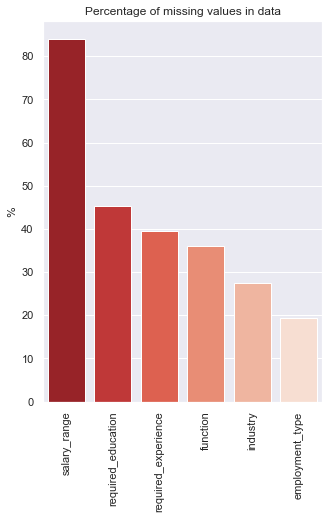

In [5]:
# check target nan value in the data 

combined = df.copy()
nan_percentage = combined.isnull().sum().sort_values(ascending=False) / combined.shape[0]
missing_val = nan_percentage[nan_percentage > 0]

plt.figure(figsize=(5,7))
sns.barplot(x=missing_val.index.values, y=missing_val.values * 100, palette="Reds_r");
plt.title("Percentage of missing values in data");
plt.ylabel("%");
plt.xticks(rotation=90);

# Taking care NaN value

```
Because salary_range has more than 50% NaN value of the data, so we will drop the feature of salary range. And the rest that contain NaN value is required_education, required_experience, function, industry, and employment_type. Those field which contain NaN value less than 50% will not dropped and will be replaced by string '-'. The reason why those value is not dropped or not replaced by other string that have rasional value is because in this case we think NaN value is not a missing value. So instead of we dropped or replace with rasional value, we think that NaN value is literally still NaN value.
```

In [6]:
# Drop column salary range 

df = df.drop(['salary_range'], axis=1)

In [7]:
# Replace NaN with '-' string

df = df.fillna('-')

In [8]:
df.head()

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,0,1,0,Other,Internship,-,-,Marketing,0
1,0,1,0,Full-time,Not Applicable,-,Marketing and Advertising,Customer Service,0
2,0,1,0,-,-,-,-,-,0
3,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


# Encode categorical variable from the data

In [9]:
pd.DataFrame([{'employment_type': len(df['employment_type'].value_counts()),    
               'required_experience': len(df['required_experience'].value_counts()),
               'required_education': len(df['required_education'].value_counts()),
               'industry': len(df['industry'].value_counts()),
               'function': len(df['function'].value_counts()),
              }], columns = ['employment_type', 'required_experience', 'required_education', 'industry', 'function'], 
              index = ['quantity of unique value'])

,employment_type,required_experience,required_education,industry,function
quantity of unique value,6,8,14,132,38


# Creating feature columns from our data

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 9 columns):
telecommuting          17880 non-null int64
has_company_logo       17880 non-null int64
has_questions          17880 non-null int64
employment_type        17880 non-null object
required_experience    17880 non-null object
required_education     17880 non-null object
industry               17880 non-null object
function               17880 non-null object
fraudulent             17880 non-null int64
dtypes: int64(4), object(5)
memory usage: 1.2+ MB


In [18]:
CATEGORICAL_COLUMNS = ['employment_type', 'required_experience', 'required_education', 'industry', 'function']
NUMERIC_COLUMNS = ['telecommuting', 'has_company_logo']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
    vocabulary = df[feature_name].unique()
    feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

# Splitting the data

In [19]:
X=df.drop("fraudulent", axis=1)
y=df["fraudulent"]

In [20]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.33, random_state=7)

# Define input function

In [22]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
    def input_function():
        ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
        if shuffle:
            ds = ds.shuffle(1000)
        ds = ds.batch(batch_size).repeat(num_epochs)
        return ds
    return input_function

train_input_fn = make_input_fn(X_train, y_train)
eval_input_fn = make_input_fn(X_test, y_test, num_epochs=1, shuffle=False)

In [24]:
ds = make_input_fn(X_train, y_train, batch_size=10)()
for feature_batch, label_batch in ds.take(1):
    print('Some feature keys:', list(feature_batch.keys()))
    print()
    print('A batch of class:', feature_batch['employment_type'].numpy())
    print()
    print('A batch of Labels:', label_batch.numpy())

Some feature keys: ['telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 'required_experience', 'required_education', 'industry', 'function']

A batch of class: [b'Full-time' b'Part-time' b'Full-time' b'Full-time' b'Full-time'
 b'Full-time' b'Full-time' b'-' b'Full-time' b'Full-time']

A batch of Labels: [0 0 0 0 0 0 0 0 1 0]


In [28]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.9511947, 'accuracy_baseline': 0.9493306, 'auc': 0.8759303, 'auc_precision_recall': 0.38291734, 'average_loss': 0.14354402, 'label/mean': 0.05066938, 'loss': 0.14323993, 'precision': 0.59016395, 'prediction/mean': 0.044198394, 'recall': 0.12040134, 'global_step': 3750}
